In [57]:
import pandas as pd
import sklearn
import statsmodels
import scipy

print('pandas: ',pd.__version__)
print('sklearn: ',sklearn.__version__)
print('statsmodels: ',statsmodels.__version__)
print('scipy: ',scipy.__version__)


pandas:  0.24.2
sklearn:  0.21.2
statsmodels:  0.10.0
scipy:  1.3.0


In [58]:
from capstone_data_eng import *
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint
from plotting_functions import *


from scipy.stats import randint as sp_randint , uniform

from matplotlib.colors import BoundaryNorm, LogNorm
from statsmodels.stats.proportion import proportion_confint

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc , confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, auc

from inspect import signature

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import pickle

In [59]:
out, profile_all, portfolio, offers_all, transactions_all, transactions_during_offer, transactions_outside_offer = load_data_cv(
        person_split=None, rename_offers=True, time_split_min=None, time_split_max=None,
        add_transactions=False, skip_overlap=False, skip_add_purchases=False, calc_net_offer_time=True,
        assign_to='ignore', location='local')

/home/marco/UD/Starbucks_capstone/capstone_data_eng.py:741: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  profile_all = load_profile(location=location)


offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64
er,ec,ev
(76277, 3) (33579, 4) (57725, 3)
er  (76277, 6)
persons with no offers received in timeframe:  6
transactions_during_offer.shape: (122652, 7)
(76277, 27)
add_stats_by_person:
(76277, 38)
(76277, 44)
(76277, 50)
(76277, 51)
(76277, 60)


## Imputation of missing values

We use the mean values extracted in the EDA part to impute missing values.
We also create the features discussed in the EDA part.

In [60]:
out.income=out.income.fillna(65400)
out.age=out.age.fillna(54)
out.gender=out.gender.fillna('M')
out['group118']=out['age']>116
out.loc[out['age']>116,'age']=54

out['binned_income'] = pd.cut(out['income'],bins= np.arange(0,14)*1e4,labels=np.arange(0,13)*10)
out['binned_age'] = pd.cut(out['age'],bins= np.arange(0,120,10) ,labels=np.arange(0,120,10)[:-1])

# Cost of offers not viewed but rewarded

In [61]:
completed_stats=out[['rewarded','completed','comp_not_viewed']].sum()
n_cnv_offers=completed_stats['comp_not_viewed']

completed_stats=completed_stats/len(out)
perc_cnv=100.*completed_stats['comp_not_viewed']



print('%3.2g%% of the total offers are rewarded even if they were not viewed\n' % (perc_cnv))
print('%3.2g%% of the rewarded offers are rewarded even if they were not viewed\n' % ( 100* completed_stats['comp_not_viewed']/(completed_stats['comp_not_viewed']+completed_stats['completed']) ))

print()
print(completed_stats.to_string())

rewards_lost=out.loc[out.comp_not_viewed,'reward'].sum()
total_rewards=out.loc[out.rewarded,'reward'].sum()

print()
print('%g$ out of total rewards %g$ could be saved (%4.3g%%)' %(rewards_lost,total_rewards,100.*rewards_lost/total_rewards))
print('average reward saved per correct offer not sent: %2.2g $' % (rewards_lost/n_cnv_offers) )

7.4% of the total offers are rewarded even if they were not viewed

 17% of the rewarded offers are rewarded even if they were not viewed


rewarded           0.435190
completed          0.361197
comp_not_viewed    0.073993

26257$ out of total rewards 162510$ could be saved (16.2%)
average reward saved per correct offer not sent: 4.7 $


# Are rewards increasing the amount of purchases per hour?

In [64]:
T_offers= out['Tpay_offer'].sum()
T_rewards=out.loc[out.rewarded,'reward'].sum()

T_income_off=T_offers-T_rewards
print('total purchases in offer time: %d $' % T_offers)
print('total rewards:                 %d $'% T_rewards)
print('total revenues during offers   %d $: '% T_income_off)


total purchases in offer time: 1356770 $
total rewards:                 162510 $
total revenues during offers   1194260 $: 


In [66]:
TO=out.groupby(by='person')['Tpay_out'].agg('mean')
T_outside= TO.sum()
print('total revenues outside of offers: %d $' % T_outside)

total revenues outside of offers: 248640 $


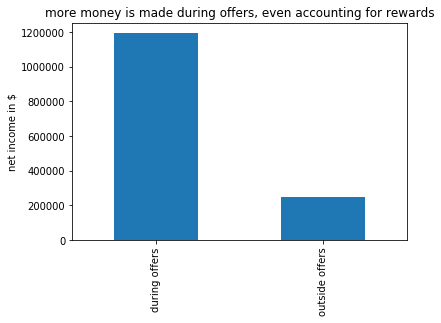

In [68]:
outcome=pd.DataFrame([[T_income_off,T_outside]],columns= ['during offers','outside offers'])
outcome.T.plot(kind='bar')
plt.gca().get_legend().remove()
plt.ylabel('net income in $');
plt.title('more money is made during offers, even accounting for rewards');

In [75]:
times=out.groupby(by='person')[['tot_net_offers_time','tot_not_offers_time']].agg('mean').sum()

hourly_offers=T_income_off/times['tot_net_offers_time']
hourly_no_offers=T_outside/times['tot_not_offers_time']
print('net hourly revenues during offers: %3.4g $/h' % (hourly_offers))
print('hourly revenues outside of offers: %3.4g $/h' % (hourly_no_offers))

net_offer_hourly=T_income_off/times['tot_net_offers_time'] - T_outside/times['tot_not_offers_time']

times=times/1e6
times=times.rename(index={'tot_net_offers_time':'hours with offers','tot_not_offers_time':'hours without offers'})

net hourly revenues during offers: 0.1908 $/h
hourly revenues outside of offers: 0.03895 $/h


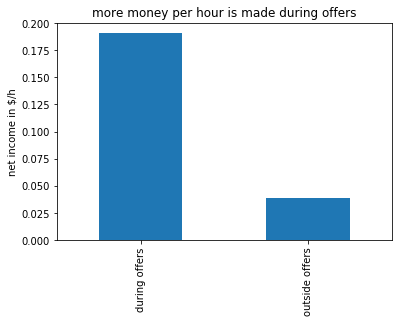

In [77]:
outcome_h=pd.DataFrame([[hourly_offers,hourly_no_offers]],columns= ['during offers','outside offers'])
outcome_h.T.plot(kind='bar')
plt.gca().get_legend().remove()
plt.ylabel('net income in $/h');
plt.title('more money per hour is made during offers');

## Estimation of how much more profitable offers are
We use bootstrap to estimate if we can confidently say that offers increase the hourly revenues.

In [79]:
pg=out.groupby(by='person')[['Avg_net_pay_offers','Avg_pay_outside']].agg('mean')
di=pg['Avg_net_pay_offers']-pg['Avg_pay_outside']

n = len(di)
reps = 10000
xb = np.random.choice(di, (n, reps))
mb = xb.mean(axis=0)
mb.sort()

mean_95p=np.percentile(mb, [0.5, 99.5])

[0.10220586 0.13058175]


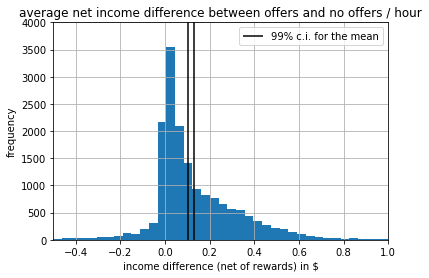

In [80]:
print('95% confidence interval: ',mean_95p)
di.hist(bins=2000)
plt.axis([-.5,1,0,4000]);
plt.title('average net income difference between offers and no offers / hour');
plt.xlabel('income difference (net of rewards) in $')
plt.ylabel('frequency');
plt.vlines(mean_95p,0,4000,label='99% c.i. for the mean')

plt.legend()

95% confidence interval:  [0.06241348 0.12794577]


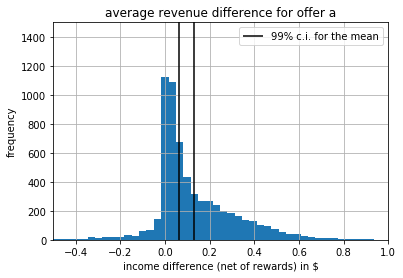

In [84]:
offer='a'

pg=out.loc[out.offer==offer].groupby(by='person')[['Avg_net_pay_offers','Avg_pay_outside']].agg('mean')
di=pg['Avg_net_pay_offers']-pg['Avg_pay_outside']

n = len(di)
reps = 10000
xb = np.random.choice(di, (n, reps))
mb = xb.mean(axis=0)
mb.sort()

mean_95p=np.percentile(mb, [0.5, 99.5])

print('95% confidence interval: ',mean_95p)
di.hist(bins=2000)
plt.axis([-.5,1,0,1500]);
plt.title('average revenue difference for offer %s' % offer);
plt.xlabel('income difference (net of rewards) in $')
plt.ylabel('frequency');
plt.vlines(mean_95p,0,4000,label='99% c.i. for the mean')

plt.legend()

In [87]:
revenue_difference={}

for offer in ['a', 'b', 'c', 'd', 'e' ,'f', 'g', 'h', 'i', 'j']:

    pg=out.loc[out.offer==offer].groupby(by='person')[['Avg_net_pay_offers','Avg_pay_outside']].agg('mean')
    di=pg['Avg_net_pay_offers']-pg['Avg_pay_outside']

    n = len(di)
    reps = 10000
    xb = np.random.choice(di, (n, reps))
    mb = xb.mean(axis=0)
    mb.sort()

    mean_95p=np.percentile(mb, [0.5, 99.5])
    revenue_difference[offer]=mean_95p
    print('offer %s: ' % offer ,mean_95p)


offer a:  [0.05947532 0.12783509]
offer b:  [0.10786318 0.13247795]
offer c:  [0.07968373 0.12775075]
offer d:  [0.08384466 0.14044307]
offer e:  [0.1133562  0.14274345]
offer f:  [0.1244735  0.14711161]
offer g:  [0.06035866 0.12642638]
offer h:  [0.09809667 0.12561544]
offer i:  [0.11345502 0.13692824]
offer j:  [0.04717354 0.11716283]


In [95]:
rev=pd.DataFrame(revenue_difference).T
rev.columns=['lower bound','upper bound']

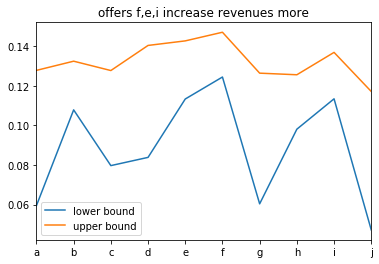

In [99]:
rev.plot()
plt.title('offers f,e,i increase revenues more');

# Customers with negative response to offers

In [103]:
resp=out.loc[out.viewed].groupby(by='person')['Avg_D_nOS'].agg('mean')
neg_resp=resp.loc[resp<-.1]

In [110]:
profile_all['neg_response']=False
profile_all.loc[profile_all.person.isin(neg_resp.index),'neg_response']=True


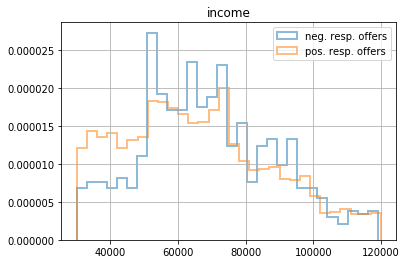

In [112]:
var='income'
bins=30
profile_all.loc[profile_all.neg_response==True, var].hist(bins=bins,histtype='step',lw=2,label='neg. resp. offers',density=True,alpha=0.5);
profile_all.loc[profile_all.neg_response==False,var].hist(bins=bins,histtype='step',lw=2,label='pos. resp. offers',density=True,alpha=0.5);

plt.legend(loc=1);
plt.title(var);

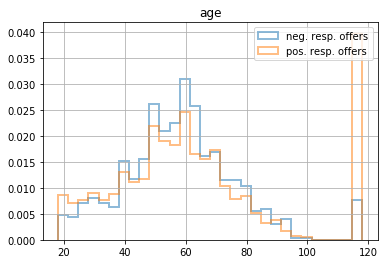

In [113]:
var='age'
bins=30
profile_all.loc[profile_all.neg_response==True, var].hist(bins=bins,histtype='step',lw=2,label='neg. resp. offers',density=True,alpha=0.5);
profile_all.loc[profile_all.neg_response==False,var].hist(bins=bins,histtype='step',lw=2,label='pos. resp. offers',density=True,alpha=0.5);

plt.legend(loc=1);
plt.title(var);

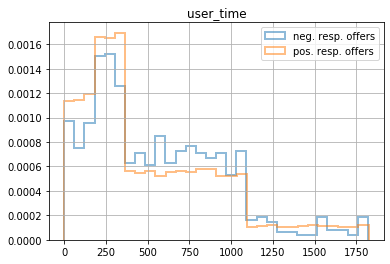

In [114]:
var='user_time'
bins=30
profile_all.loc[profile_all.neg_response==True, var].hist(bins=bins,histtype='step',lw=2,label='neg. resp. offers',density=True,alpha=0.5);
profile_all.loc[profile_all.neg_response==False,var].hist(bins=bins,histtype='step',lw=2,label='pos. resp. offers',density=True,alpha=0.5);

plt.legend(loc=1);
plt.title(var);

gender,F,M,O
neg_response,,,
False,0.408109,0.577923,0.013967
True,0.507576,0.472222,0.020202


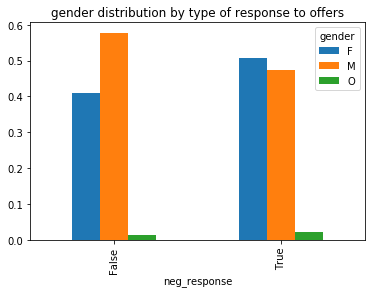

In [115]:
var='gender'
vis=profile_all.groupby(by='neg_response')[var].value_counts(normalize=True).unstack()
display(vis)

vis.plot(kind='bar')
plt.title('gender distribution by type of response to offers');